[https://www.kaggle.com/code/samanemami/gan-on-tabular-data](https://www.kaggle.com/code/samanemami/gan-on-tabular-data)
<br>
[https://ksquarej.medium.com/conditional-gan-generative-adversarial-network-on-tabular-data-5f1482228a00](https://ksquarej.medium.com/conditional-gan-generative-adversarial-network-on-tabular-data-5f1482228a00)

In [ ]:
!pip install pingouin
!pip install statstests
!pip install statsmodels
# !pip install opacus

## Importing libraries

In [ ]:
import pandas as pd
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import plotly.graph_objects as go # gráficos 3D
from scipy.stats import pearsonr # correlações de Pearson
import statsmodels.api as sm # estimação de modelos
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from sklearn.preprocessing import LabelEncoder # transformação de dados
from sklearn.preprocessing import MinMaxScaler
import pingouin as pg # outro modo para obtenção de matrizes de correlações
from statstests.process import stepwise # procedimento Stepwise
from statstests.tests import shapiro_francia # teste de Shapiro-Francia
from scipy.stats import boxcox # transformação de Box-Cox
from scipy.stats import norm # para plotagem da curva normal
from scipy import stats # utilizado na definição da função 'breusch_pagan_test'

from scipy.stats import ks_2samp
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torchsummary import summary

import random

In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)  # PyTorch CPU seed
    torch.cuda.manual_seed(seed)  # PyTorch GPU seed
    torch.cuda.manual_seed_all(seed)  # Multi-GPU seed
    np.random.seed(seed)  # NumPy seed
    random.seed(seed)  # Python seed

    # Ensure deterministic behavior (slightly slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Ensures consistent results

set_seed(42)  # Call before running your code

## Importing the data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/IA/Data/parkinsons.csv',
                   encoding='utf-8', quotechar='"', delimiter=',')
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


## Analysing the data

In [ ]:
data.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

- **name** ASCII subject name and recording number
- **status** Health status of the subject (one) - Parkinson's, (zero) - healthy

[Vocal](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4380292/#:~:text=In%20Parkinson's%20Disease%20(PD)%2C,changes%20are%20not%20well%20documented.)
<br>
[Dysphonic Voice Pattern Analysis of Patients in Parkinson's Disease](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5434464/)
- **MDVP:F0 (Hz)**	Average vocal fundamental frequency
- **MDVP:Fhi (Hz)**	Maximum vocal fundamental frequency
- **MDVP:Flo (Hz)**	Minimum vocal fundamental frequency
- **MDVP:Jitter(%)**	MDVP jitter in percentage
- **MDVP:Jitter(Abs)**	MDVP absolute jitter in ms
- **MDVP:RAP**	MDVP relative amplitude perturbation
- **MDVP:PPQ**	MDVP five-point period perturbation quotient
- **Jitter:DDP**	Average absolute difference of differences between jitter cycles
- **MDVP:Shimmer**	MDVP local shimmer
- **MDVP:Shimmer(dB)**	MDVP local shimmer in dB
- **Shimmer:APQ3**	Three-point amplitude perturbation quotient
- **Shimmer:APQ5**	Five-point amplitude perturbation quotient
- **MDVP:APQ11**	MDVP 11-point amplitude perturbation quotient
- **Shimmer:DDA**	Average absolute differences between the amplitudes of consecutive periods
- **NHR**	Noise-to-harmonics ratio
- **HNR**	Harmonics-to-noise ratio
- **RPDE**	Recurrence period density entropy measure
- **D2**	Correlation dimension
- **DFA**	Signal fractal scaling exponent of detrended fluctuation analysis
- **Spread1**	Two nonlinear measures of fundamental
- **Spread2**	Frequency variation
- **PPE**	Pitch period entropy

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [ ]:
# Dropping the name column
data.drop('name', axis=1, inplace=True)
data.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [ ]:
data.shape

(195, 23)

In [ ]:
data['NHR'].dtype, data['MDVP:Fo(Hz)'].dtype, data['status'].dtype

(dtype('float64'), dtype('float64'), dtype('int64'))

In [ ]:
# Changing 'status' to object
data['status'] = data['status'].astype('object')
data['status'].dtype

dtype('O')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MDVP:Fo(Hz)       195 non-null    float64
 1   MDVP:Fhi(Hz)      195 non-null    float64
 2   MDVP:Flo(Hz)      195 non-null    float64
 3   MDVP:Jitter(%)    195 non-null    float64
 4   MDVP:Jitter(Abs)  195 non-null    float64
 5   MDVP:RAP          195 non-null    float64
 6   MDVP:PPQ          195 non-null    float64
 7   Jitter:DDP        195 non-null    float64
 8   MDVP:Shimmer      195 non-null    float64
 9   MDVP:Shimmer(dB)  195 non-null    float64
 10  Shimmer:APQ3      195 non-null    float64
 11  Shimmer:APQ5      195 non-null    float64
 12  MDVP:APQ          195 non-null    float64
 13  Shimmer:DDA       195 non-null    float64
 14  NHR               195 non-null    float64
 15  HNR               195 non-null    float64
 16  status            195 non-null    object 
 1

In [ ]:
data.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.024081,0.046993,0.024847,21.885974,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.016947,0.030459,0.040418,4.425764,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.007190,0.013640,0.000650,8.441000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.013080,0.024735,0.005925,19.198000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.018260,0.038360,0.011660,22.085000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.029400,0.060795,0.025640,25.075500,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.137780,0.169420,0.314820,33.047000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


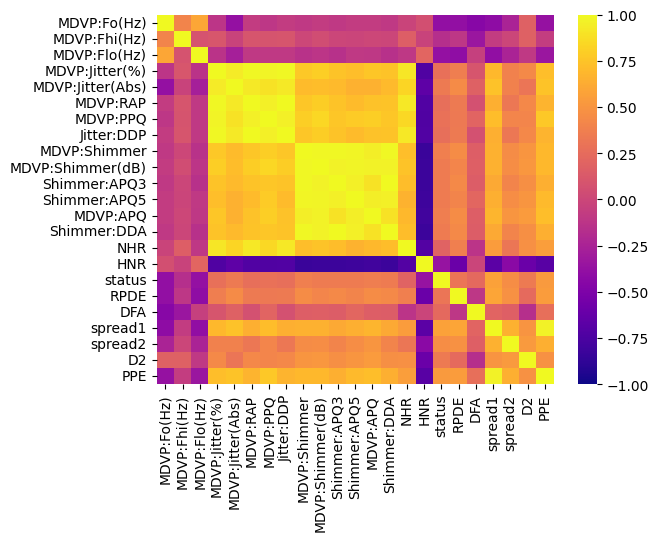

In [ ]:
heatmap = sns.heatmap(data.corr(), annot=False, fmt='.3f',
                      cmap=plt.cm.plasma,
                      annot_kws={'size':10}, vmin=-1, vmax=1)

<Axes: xlabel='status', ylabel='count'>

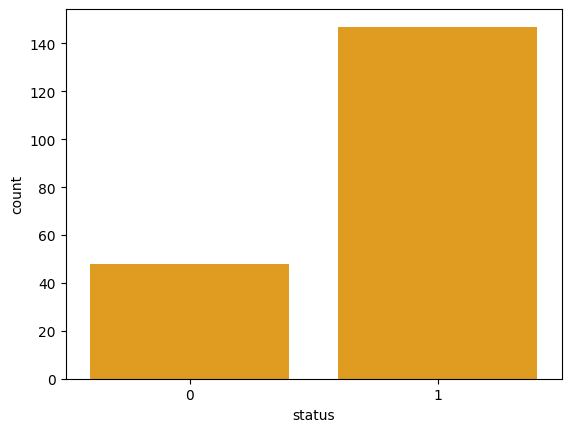

In [ ]:
sns.barplot(data['status'].value_counts(), color='orange')

In [ ]:
## Analysing Pearson's correlation coefficient between variables
pg.rcorr(data.drop('status', axis=1),
         method='pearson', upper='pval',
         decimals=4,
         pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
MDVP:Fo(Hz),-,***,***,,***,,,,,,...,,,,,***,***,***,***,**,***
MDVP:Fhi(Hz),0.401,-,,,,,,,,,...,,,**,,,***,,,**,
MDVP:Flo(Hz),0.5965,0.085,-,*,***,,,,**,*,...,,**,,***,***,,***,***,,***
MDVP:Jitter(%),-0.118,0.1021,-0.1399,-,***,***,***,***,***,***,...,***,***,***,***,***,,***,***,***,***
MDVP:Jitter(Abs),-0.382,-0.0292,-0.2778,0.9357,-,***,***,***,***,***,...,***,***,***,***,***,**,***,***,***,***
MDVP:RAP,-0.0762,0.0972,-0.1005,0.9903,0.9229,-,***,***,***,***,...,***,***,***,***,***,,***,***,***,***
MDVP:PPQ,-0.1122,0.0911,-0.0958,0.9743,0.8978,0.9573,-,***,***,***,...,***,***,***,***,***,***,***,***,***,***
Jitter:DDP,-0.0762,0.0971,-0.1005,0.9903,0.9229,1.0,0.9573,-,***,***,...,***,***,***,***,***,,***,***,***,***
MDVP:Shimmer,-0.0984,0.0023,-0.1445,0.7691,0.7033,0.7596,0.7978,0.7596,-,***,...,***,***,***,***,***,**,***,***,***,***
MDVP:Shimmer(dB),-0.0737,0.0435,-0.1191,0.8043,0.7166,0.7907,0.8392,0.7906,0.9873,-,...,***,***,***,***,***,**,***,***,***,***


## Multiple Regression Model Estimation

In [ ]:
data.rename(columns={'MDVP:Fo(Hz)': 'Fo', 'MDVP:Fhi(Hz)': 'Fhi',
    'MDVP:Flo(Hz)': 'Flo', 'MDVP:Jitter(%)': 'Jitter_Percent',
    'MDVP:Jitter(Abs)': 'Jitter_Abs', 'MDVP:RAP': 'RAP',
    'MDVP:PPQ': 'PPQ', 'Jitter:DDP': 'DDP', 'MDVP:Shimmer': 'Shimmer',
    'MDVP:Shimmer(dB)': 'Shimmer_dB', 'Shimmer:APQ3': 'Shimmer_APQ3',
    'Shimmer:APQ5': 'Shimmer_APQ5', 'MDVP:APQ': 'APQ', 'Shimmer:DDA': 'Shimmer_DDA'},
            inplace=True)

In [ ]:
# Normalizing columns
negative_cols = data.columns[data.min() < 0]
print(negative_cols)

positive_cols = data.columns[~data.columns.isin(negative_cols)]
print(positive_cols)

Index(['spread1'], dtype='object')
Index(['Fo', 'Fhi', 'Flo', 'Jitter_Percent', 'Jitter_Abs', 'RAP', 'PPQ', 'DDP',
       'Shimmer', 'Shimmer_dB', 'Shimmer_APQ3', 'Shimmer_APQ5', 'APQ',
       'Shimmer_DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread2', 'D2',
       'PPE'],
      dtype='object')


In [ ]:
negative_scaler = MinMaxScaler(feature_range=(-1, 1))
positive_scaler = MinMaxScaler(feature_range=(0, 1))

data[negative_cols] = negative_scaler.fit_transform(data[negative_cols])
data[positive_cols] = positive_scaler.fit_transform(data[positive_cols])
data.describe()

,Fo,Fhi,Flo,Jitter_Percent,Jitter_Abs,RAP,PPQ,DDP,Shimmer,Shimmer_dB,...,Shimmer_DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.383623,0.193841,0.292748,0.144233,0.146083,0.126513,0.135389,0.126504,0.184126,0.162080,...,0.214101,0.077019,0.546410,0.753846,0.564574,0.572963,-0.175337,0.495783,0.426421,0.335549
std,0.240959,0.186761,0.250564,0.154007,0.137636,0.142956,0.147855,0.142934,0.172147,0.160129,...,0.195527,0.128652,0.179865,0.431878,0.242525,0.220456,0.394221,0.187758,0.170294,0.186649
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,0.170220,0.066786,0.108323,0.056544,0.051383,0.047206,0.050375,0.047279,0.063584,0.052177,...,0.071222,0.016790,0.437170,1.000000,0.384375,0.400291,-0.452214,0.378364,0.300658,0.192433
50%,0.351961,0.150411,0.223606,0.103558,0.090909,0.087669,0.094855,0.087494,0.122604,0.111750,...,0.158685,0.035045,0.554499,1.000000,0.558550,0.589516,-0.188525,0.478618,0.417393,0.309661
75%,0.549775,0.249162,0.429160,0.180591,0.209486,0.151975,0.162647,0.151951,0.258764,0.217749,...,0.302703,0.079543,0.676034,1.000000,0.772299,0.747391,0.055439,0.614472,0.539698,0.431709
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Creating a Generative Adversarial Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torchsummary import summary

In [ ]:
data['status'] = data['status'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Fo              195 non-null    float64
 1   Fhi             195 non-null    float64
 2   Flo             195 non-null    float64
 3   Jitter_Percent  195 non-null    float64
 4   Jitter_Abs      195 non-null    float64
 5   RAP             195 non-null    float64
 6   PPQ             195 non-null    float64
 7   DDP             195 non-null    float64
 8   Shimmer         195 non-null    float64
 9   Shimmer_dB      195 non-null    float64
 10  Shimmer_APQ3    195 non-null    float64
 11  Shimmer_APQ5    195 non-null    float64
 12  APQ             195 non-null    float64
 13  Shimmer_DDA     195 non-null    float64
 14  NHR             195 non-null    float64
 15  HNR             195 non-null    float64
 16  status          195 non-null    int64  
 17  RPDE            195 non-null    flo

In [ ]:
data_no_status = data.drop('status', axis=1)

In [ ]:
import pandas as pd

# Example dataset with 22 float columns and 1 binary column (0 or 1)
X = data.drop('status', axis=1)  # The 22 float columns (features)
X = X.values

class CustomDataset(Dataset):
    def __init__(self, X):
        self.X = torch.FloatTensor(X)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

# Create the dataset and dataloader
dataset = CustomDataset(X)
# dataloader = DataLoader(dataset, batch_size=13, shuffle=True)
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)

In [ ]:
dataloader.dataset.X.shape

torch.Size([195, 22])

### Trying to Enhance the Model (Model 3)

#### Creating the model

In [ ]:
# Hyperparameters
# batch_size = 32
noise_dim = 100  # Dimensionality of the noise vector
output_dim = 22  # The number of output features (22 float columns)
num_epochs = 200
lr_D = 0.0002
lr_G = 0.0002

In [ ]:
class Generator_3(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator_3, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, output_dim),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.model(noise)

In [ ]:
class Discriminator_3(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator_3, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(128, 1)
        )

    def forward(self, data):
        return self.model(data)

In [ ]:
generator_3 = Generator_3(noise_dim, output_dim)
summary(generator_3, input_size=[(noise_dim,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          12,928
              ReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                  [-1, 256]          33,024
              ReLU-5                  [-1, 256]               0
           Dropout-6                  [-1, 256]               0
            Linear-7                  [-1, 512]         131,584
              ReLU-8                  [-1, 512]               0
           Dropout-9                  [-1, 512]               0
           Linear-10                   [-1, 22]          11,286
             Tanh-11                   [-1, 22]               0
Total params: 188,822
Trainable params: 188,822
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
discriminator_3 = Discriminator_3(output_dim)
summary(discriminator_3, input_size=[(output_dim,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          11,776
         LeakyReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
         LeakyReLU-5                  [-1, 256]               0
           Dropout-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
         LeakyReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                    [-1, 1]             129
Total params: 176,129
Trainable params: 176,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.67
Estimated T

In [ ]:
# all_fake_data_3 = []

In [ ]:
# Loss and optimizers
criterion = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(generator_3.parameters(), lr=lr_G)
optimizer_D = optim.Adam(discriminator_3.parameters(), lr=lr_D)

In [ ]:
# Training loop
for epoch in range(num_epochs):
    for real_data in dataloader:
        batch_size = real_data.size(0)

        real_labels = torch.full((batch_size, 1), 0.9)
        fake_labels = torch.full((batch_size, 1), 0.1)
        # real_labels = torch.ones(batch_size, 1)
        # fake_labels = torch.zeros(batch_size, 1)


        # Real data
        real_data = real_data.float()

        for _ in range(2):
            optimizer_D.zero_grad()

            output_real = discriminator_3(real_data)
            d_loss_real = criterion(output_real, real_labels)

            ## Adding Correlated Noise
            mean = torch.zeros(noise_dim)
            cov_matrix = 0.8 * torch.ones(noise_dim, noise_dim) + 0.2 * torch.eye(noise_dim)
            noise = torch.distributions.MultivariateNormal(mean, cov_matrix).sample((batch_size,))

            fake_data = generator_3(noise)
            output_fake = discriminator_3(fake_data.detach())
            d_loss_fake = criterion(output_fake, fake_labels)

            # Total Discriminator Loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward(retain_graph=True)
            optimizer_D.step()


        # Regenerate fake data for generator update (new forward pass so a fresh graph is built)
        noise = torch.distributions.MultivariateNormal(mean, cov_matrix).sample((batch_size,))
        fake_data_for_G = generator_3(noise)
        output_fake_for_G = discriminator_3(fake_data_for_G)
        g_loss = criterion(output_fake_for_G, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

Epoch [1/200], D Loss: 1.3768, G Loss: 0.8721
Epoch [2/200], D Loss: 1.3846, G Loss: 0.7231
Epoch [3/200], D Loss: 1.1492, G Loss: 1.6686
Epoch [4/200], D Loss: 0.9785, G Loss: 0.9336
Epoch [5/200], D Loss: 0.8576, G Loss: 1.6348
Epoch [6/200], D Loss: 0.9881, G Loss: 0.9551
Epoch [7/200], D Loss: 1.4087, G Loss: 1.0469
Epoch [8/200], D Loss: 0.9902, G Loss: 1.2671
Epoch [9/200], D Loss: 0.7490, G Loss: 1.5599
Epoch [10/200], D Loss: 0.9183, G Loss: 2.3402
Epoch [11/200], D Loss: 1.0627, G Loss: 1.1061
Epoch [12/200], D Loss: 1.0212, G Loss: 0.7468
Epoch [13/200], D Loss: 0.9931, G Loss: 0.7404
Epoch [14/200], D Loss: 1.1611, G Loss: 0.8726
Epoch [15/200], D Loss: 1.2518, G Loss: 0.9450
Epoch [16/200], D Loss: 0.9308, G Loss: 1.0590
Epoch [17/200], D Loss: 1.9415, G Loss: 1.2401
Epoch [18/200], D Loss: 0.7750, G Loss: 1.5623
Epoch [19/200], D Loss: 1.3494, G Loss: 0.7042
Epoch [20/200], D Loss: 1.1577, G Loss: 1.1915
Epoch [21/200], D Loss: 1.0157, G Loss: 1.8210
Epoch [22/200], D Loss

In [ ]:
# Number of synthetic rows
num_synthetic_rows = 190

# Assuming noise_dim is defined
mean = torch.zeros(noise_dim)
cov_matrix = 0.8 * torch.ones(noise_dim, noise_dim) + 0.2 * torch.eye(noise_dim)
noise = torch.distributions.MultivariateNormal(mean, cov_matrix).sample((num_synthetic_rows,))

# Generate fake data
fake_data = generator_3(noise).detach().cpu().numpy()

In [ ]:
df_fake = pd.DataFrame(fake_data, columns=data_no_status.columns)
df_fake.shape

(190, 22)

In [ ]:
import math

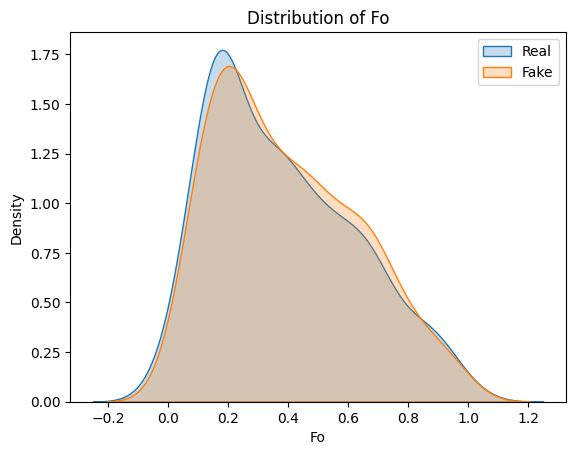

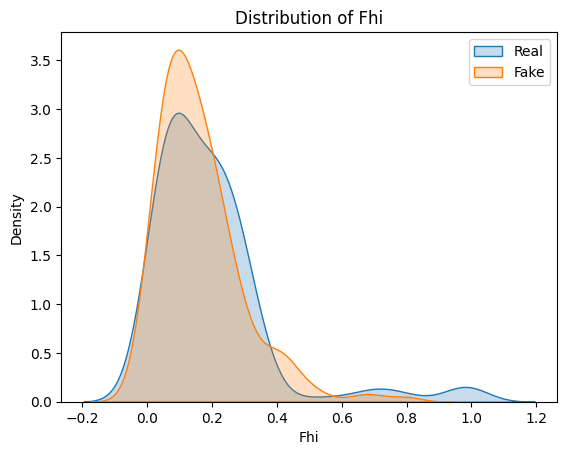

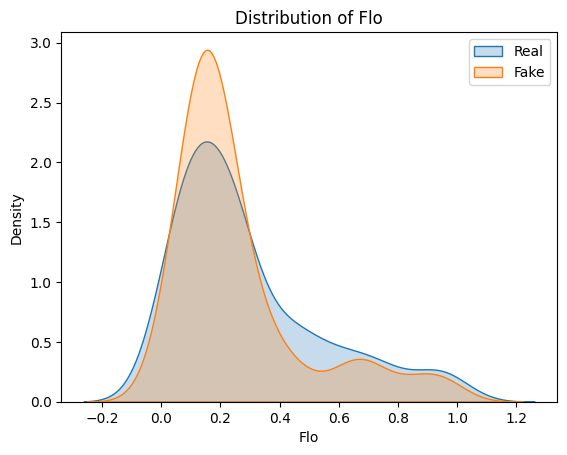

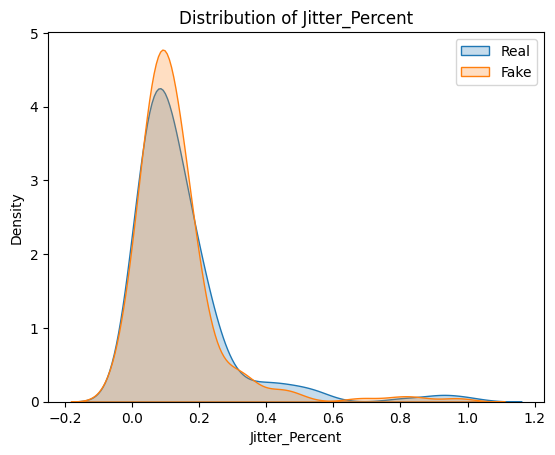

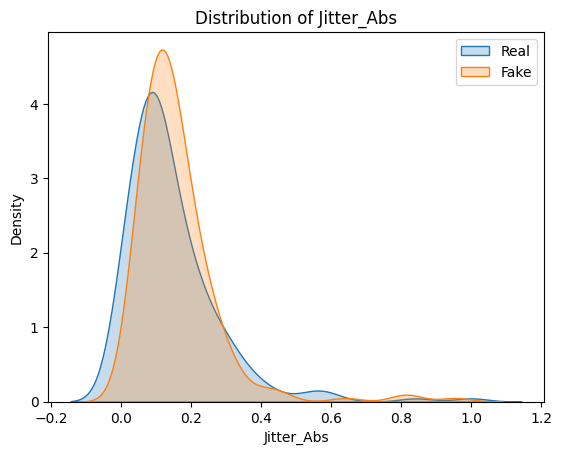

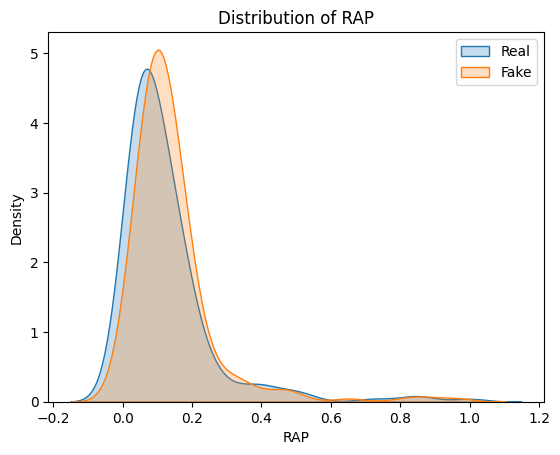

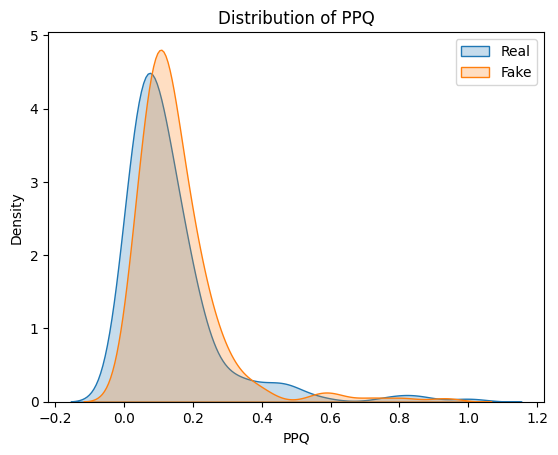

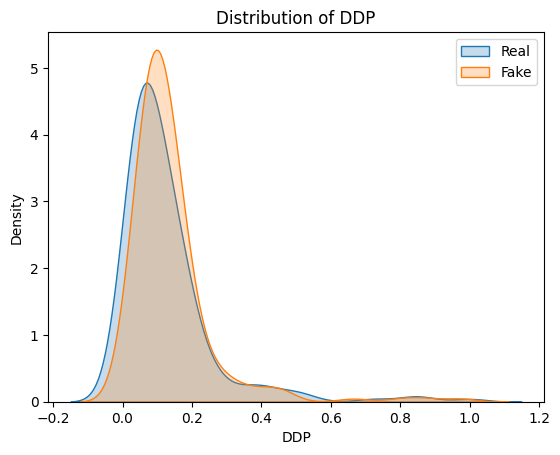

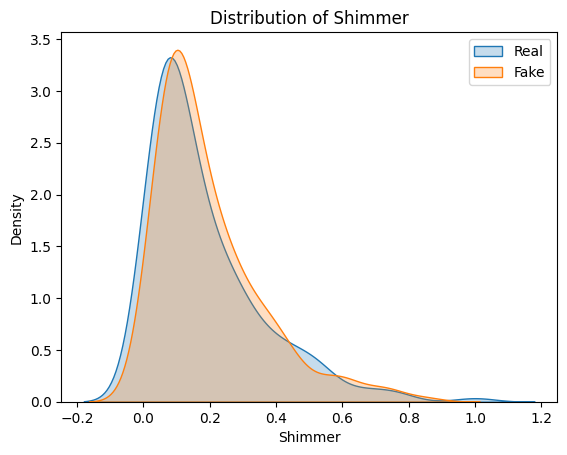

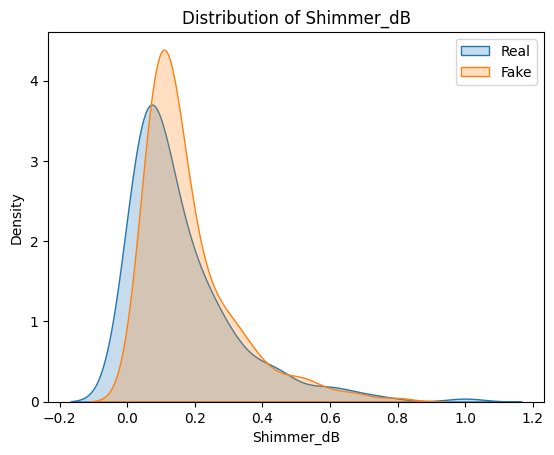

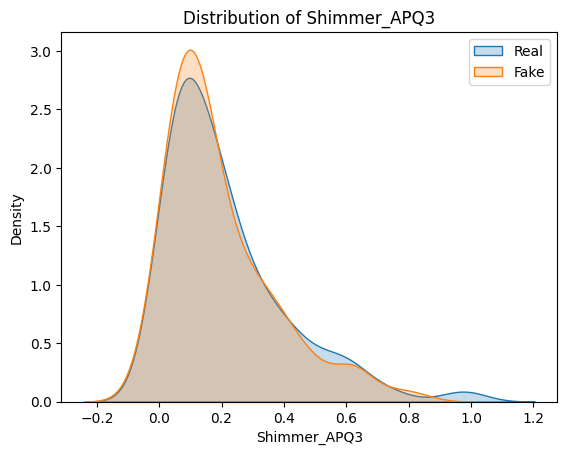

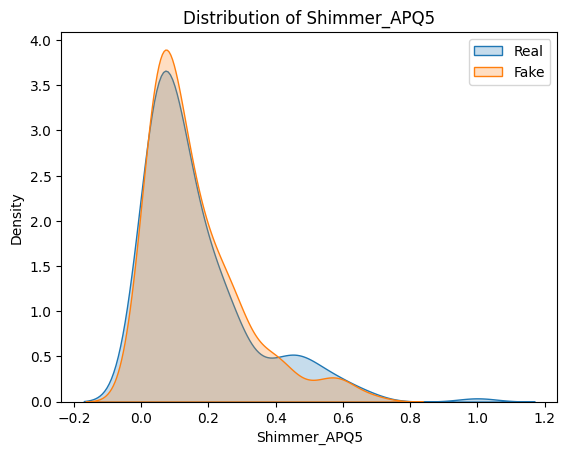

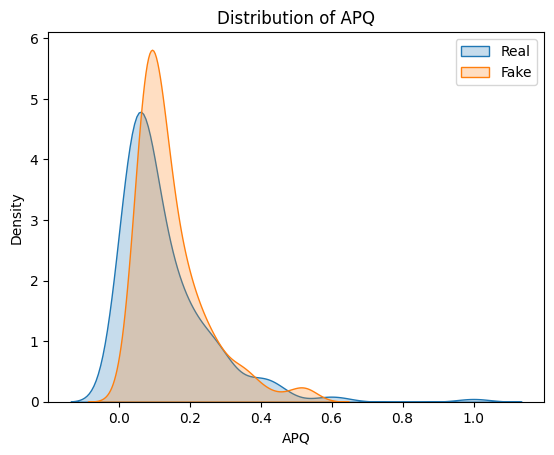

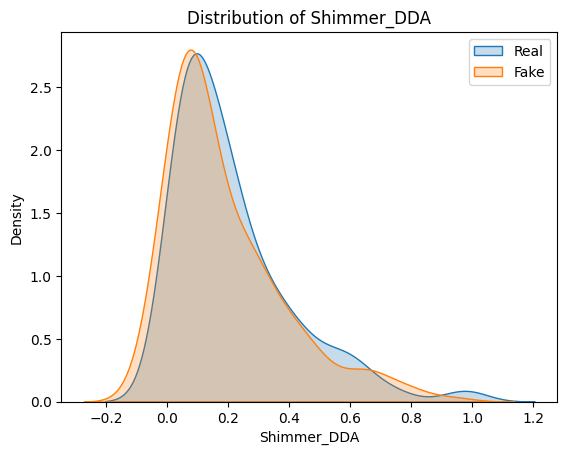

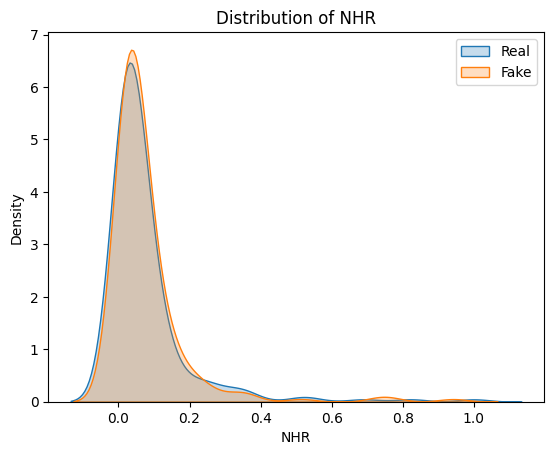

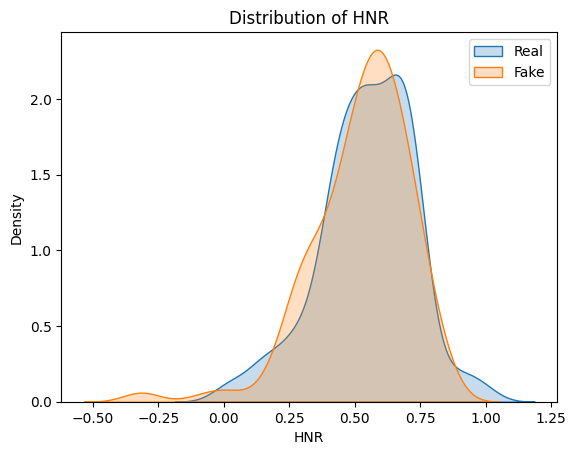

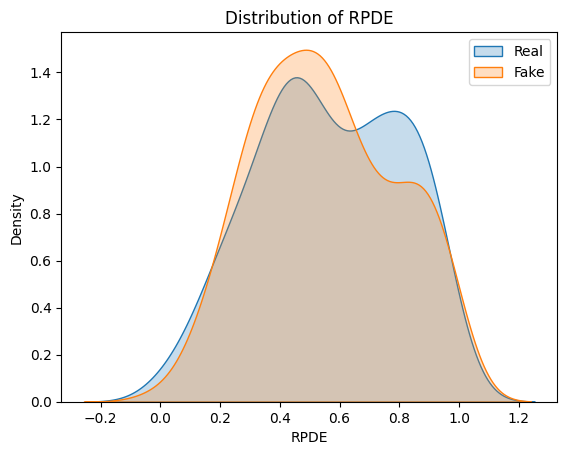

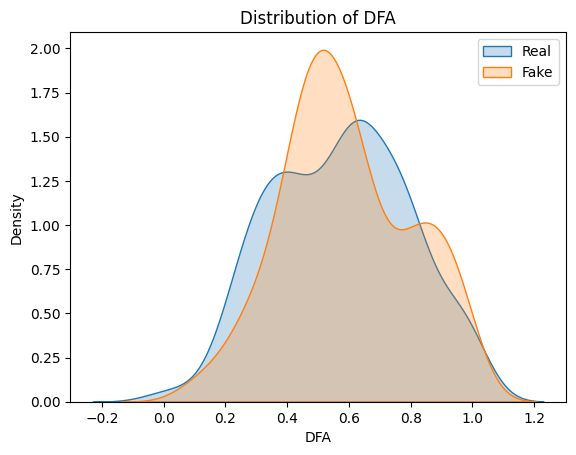

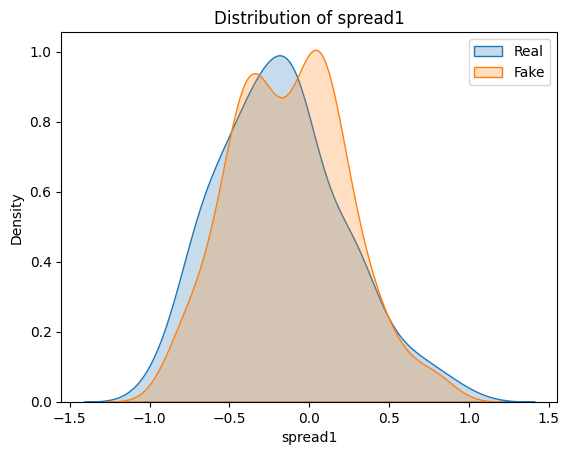

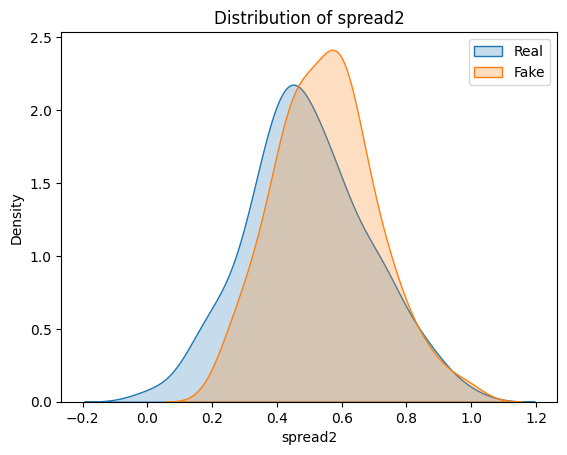

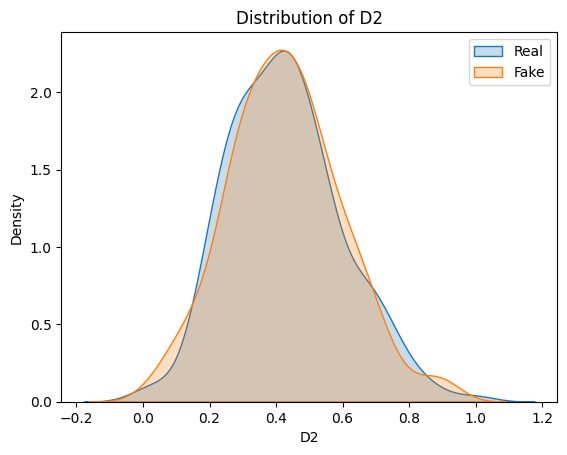

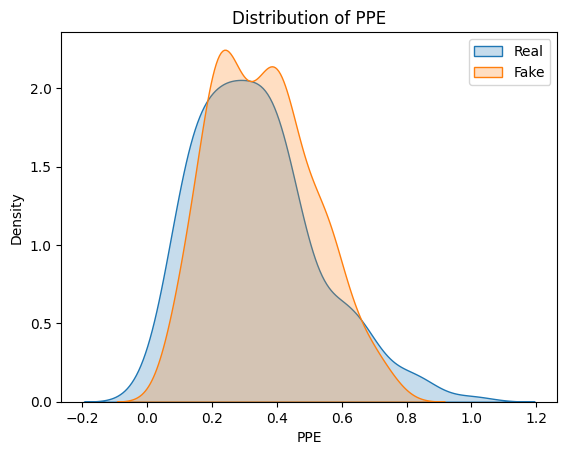

In [ ]:
for col in df_fake.columns:
    sns.kdeplot(data[col], label='Real', fill=True)
    sns.kdeplot(df_fake[col], label='Fake', fill=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()

In [ ]:
from scipy.stats import ks_2samp

- If the p-value is high (e.g., **> 0.05**), it suggests that the distributions are similar.
- A low p-value indicates significant differences.

In [ ]:
for col in df_fake.columns:
    ks_stat, p_value = ks_2samp(data[col], df_fake[col])
    print(f'{col}: K-S Test p-value = {p_value}')

Fo: K-S Test p-value = 0.43383440074491786
Fhi: K-S Test p-value = 0.09003061049735143
Flo: K-S Test p-value = 0.008671557894293313
Jitter_Percent: K-S Test p-value = 0.3570213916655409
Jitter_Abs: K-S Test p-value = 2.4613342917900828e-05
RAP: K-S Test p-value = 0.00017461053962211702
PPQ: K-S Test p-value = 0.0003939482536144724
DDP: K-S Test p-value = 0.0002788630918651006
Shimmer: K-S Test p-value = 0.05811548453365283
Shimmer_dB: K-S Test p-value = 5.864578344313219e-06
Shimmer_APQ3: K-S Test p-value = 0.6016506359940657
Shimmer_APQ5: K-S Test p-value = 0.8467195801343051
APQ: K-S Test p-value = 1.0870587923603845e-07
Shimmer_DDA: K-S Test p-value = 0.20795615130713738
NHR: K-S Test p-value = 0.1512252782658252
HNR: K-S Test p-value = 0.5148645365822049
RPDE: K-S Test p-value = 0.2715076509122604
DFA: K-S Test p-value = 0.11738749407432549
spread1: K-S Test p-value = 0.08823604867935562
spread2: K-S Test p-value = 0.006950936723405404
D2: K-S Test p-value = 0.9913403461579382
PPE:

In [ ]:
problematic_columns = []
threshold = 0.05

for col in data_no_status.columns:
    p_value = ks_2samp(data_no_status[col], df_fake[col]).pvalue
    if p_value < threshold:
        problematic_columns.append(data_no_status.columns.get_loc(col))

print(f'Columns that need fine-tuning: {problematic_columns}')

Columns that need fine-tuning: [2, 4, 5, 6, 7, 9, 12, 19]


### Saving fake data and weights

In [ ]:
df_fake.to_csv('fake_data.csv', index=False)

In [ ]:
df_fake.to_pickle('fake_data.pkl')

In [ ]:
torch.save(generator_3.state_dict(), "generator.pth")
torch.save(discriminator_3.state_dict(), "discriminator.pth")

## Checking Fake Data

In [ ]:
fake = pd.read_csv('fake_data.csv')
fake.head()

,Fo,Fhi,Flo,Jitter_Percent,Jitter_Abs,RAP,PPQ,DDP,Shimmer,Shimmer_dB,...,APQ,Shimmer_DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,0.803306,0.288173,0.194162,0.117181,0.058454,0.164694,0.126088,0.123883,0.126455,0.159598,...,0.107331,0.102359,0.080408,0.526269,0.306014,0.531563,-0.533669,0.516039,0.516354,0.169149
1,0.449775,0.188430,0.532214,0.153070,0.159613,0.190240,0.180403,0.152132,0.122477,0.103728,...,0.104111,0.082484,0.047716,0.423792,0.533164,0.859657,-0.029740,0.553284,0.546711,0.398387
2,0.567883,0.191984,0.667683,0.059705,0.075164,0.055427,0.086302,0.069507,0.100520,0.125431,...,0.108627,0.073812,0.003927,0.719328,0.085862,0.769799,-0.489820,0.258450,0.192303,0.227012
3,0.804996,0.315763,0.041482,0.143587,0.064650,0.186488,0.152337,0.149838,0.142451,0.157584,...,0.128500,0.098555,0.073892,0.569207,0.507977,0.429616,0.007671,0.743572,0.672617,0.361812
4,0.097993,-0.004052,0.173051,0.201721,0.331237,0.245090,0.226920,0.229776,0.276640,0.197854,...,0.155072,0.238158,0.144477,0.311666,0.974923,0.411953,0.411685,0.459887,0.569873,0.567430


In [ ]:
fake.shape

(190, 22)

In [ ]:
data.head()

,Fo,Fhi,Flo,Jitter_Percent,Jitter_Abs,RAP,PPQ,DDP,Shimmer,Shimmer_dB,...,Shimmer_DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,0.184308,0.112592,0.054815,0.195680,0.249012,0.145472,0.247588,0.145288,0.312215,0.280197,...,0.332584,0.068307,0.511745,1,0.369155,0.960148,0.139750,0.585765,0.390661,0.497310
1,0.198327,0.094930,0.278323,0.254130,0.288538,0.191233,0.323687,0.191042,0.472887,0.444536,...,0.516048,0.059331,0.432577,1,0.470830,0.977024,0.406554,0.741337,0.473145,0.671326
2,0.165039,0.059128,0.265288,0.280178,0.328063,0.229287,0.369239,0.229411,0.390634,0.326212,...,0.443317,0.039596,0.496220,1,0.404416,1.000000,0.273489,0.686371,0.408819,0.596682
3,0.165004,0.072927,0.264200,0.263342,0.328063,0.209056,0.324759,0.208862,0.414278,0.354971,...,0.475478,0.040997,0.495936,1,0.416255,0.975885,0.391255,0.738089,0.436977,0.671949
4,0.161150,0.080909,0.260107,0.354511,0.407115,0.282755,0.437299,0.282870,0.499452,0.410025,...,0.584542,0.054174,0.455499,1,0.375159,0.992813,0.524944,0.513798,0.404336,0.757611


In [ ]:
summary_real = data_no_status.describe().loc[['mean', 'std', '25%', '50%', '75%']]
summary_fake = fake.describe().loc[['mean', 'std', '25%', '50%', '75%']]
comparison = summary_real - summary_fake
print(comparison)

            Fo       Fhi       Flo  Jitter_Percent  Jitter_Abs       RAP  \
mean -0.013159  0.030639  0.034449        0.013391   -0.014094 -0.015848   
std   0.004300  0.053784  0.024838        0.018845    0.011903  0.009830   
25%  -0.024285 -0.003098 -0.015278       -0.005749   -0.035600 -0.027501   
50%  -0.014368  0.017374  0.043082        0.003089   -0.040759 -0.023999   
75%  -0.023480  0.030409  0.137214        0.023924    0.018337 -0.008863   

           PPQ       DDP   Shimmer  Shimmer_dB  ...       APQ  Shimmer_DDA  \
mean -0.018122 -0.012481 -0.013316   -0.020360  ... -0.019598     0.024673   
std   0.020065  0.011614  0.010764    0.022975  ...  0.029034     0.001984   
25%  -0.032308 -0.025357 -0.020522   -0.036982  ... -0.034366     0.016936   
50%  -0.025493 -0.020495 -0.023709   -0.025242  ... -0.029436     0.037397   
75%  -0.020522 -0.006352 -0.002778   -0.011085  ... -0.013520     0.020787   

           NHR       HNR      RPDE       DFA   spread1   spread2        D2

### Training a Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
fake_cp = fake.copy()
data_cp = data_no_status.copy()

In [ ]:
data_cp["label"] = 0
fake_cp["label"] = 1

combined = pd.concat([data_cp, fake_cp])
X = combined.drop("label", axis=1)
y = combined["label"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf = RandomForestClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Discrimination Accuracy: {accuracy}")

Discrimination Accuracy: 0.7844827586206896


In [ ]:
feature_importances = clf.feature_importances_
feature_names = X.columns

# Convert to a DataFrame for easier plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

<ipython-input-228-84009f7518b0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


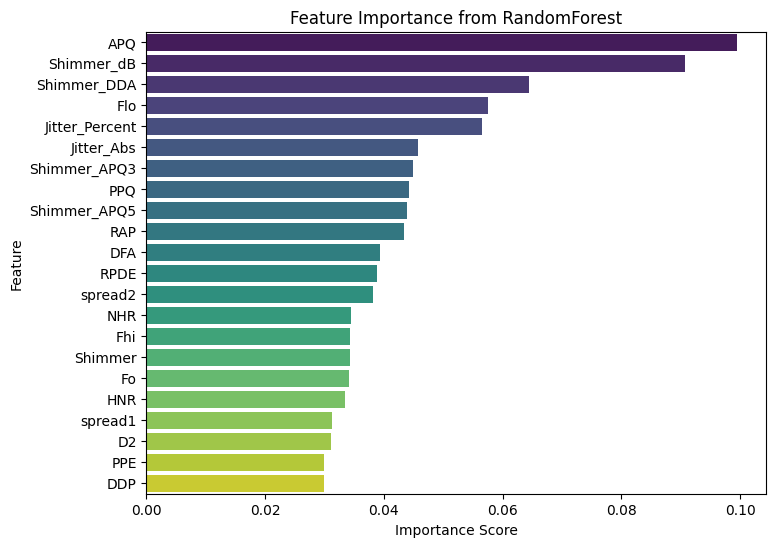

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance from RandomForest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [ ]:
teste_y = combined.drop('label', axis=1)
teste_X = combined['label']

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

RandomForestClassifier(random_state=42)

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(5)
print(top_features)

APQ               0.095922
Jitter_Abs        0.073967
Shimmer_DDA       0.070804
Shimmer_dB        0.068118
Jitter_Percent    0.058937
dtype: float64


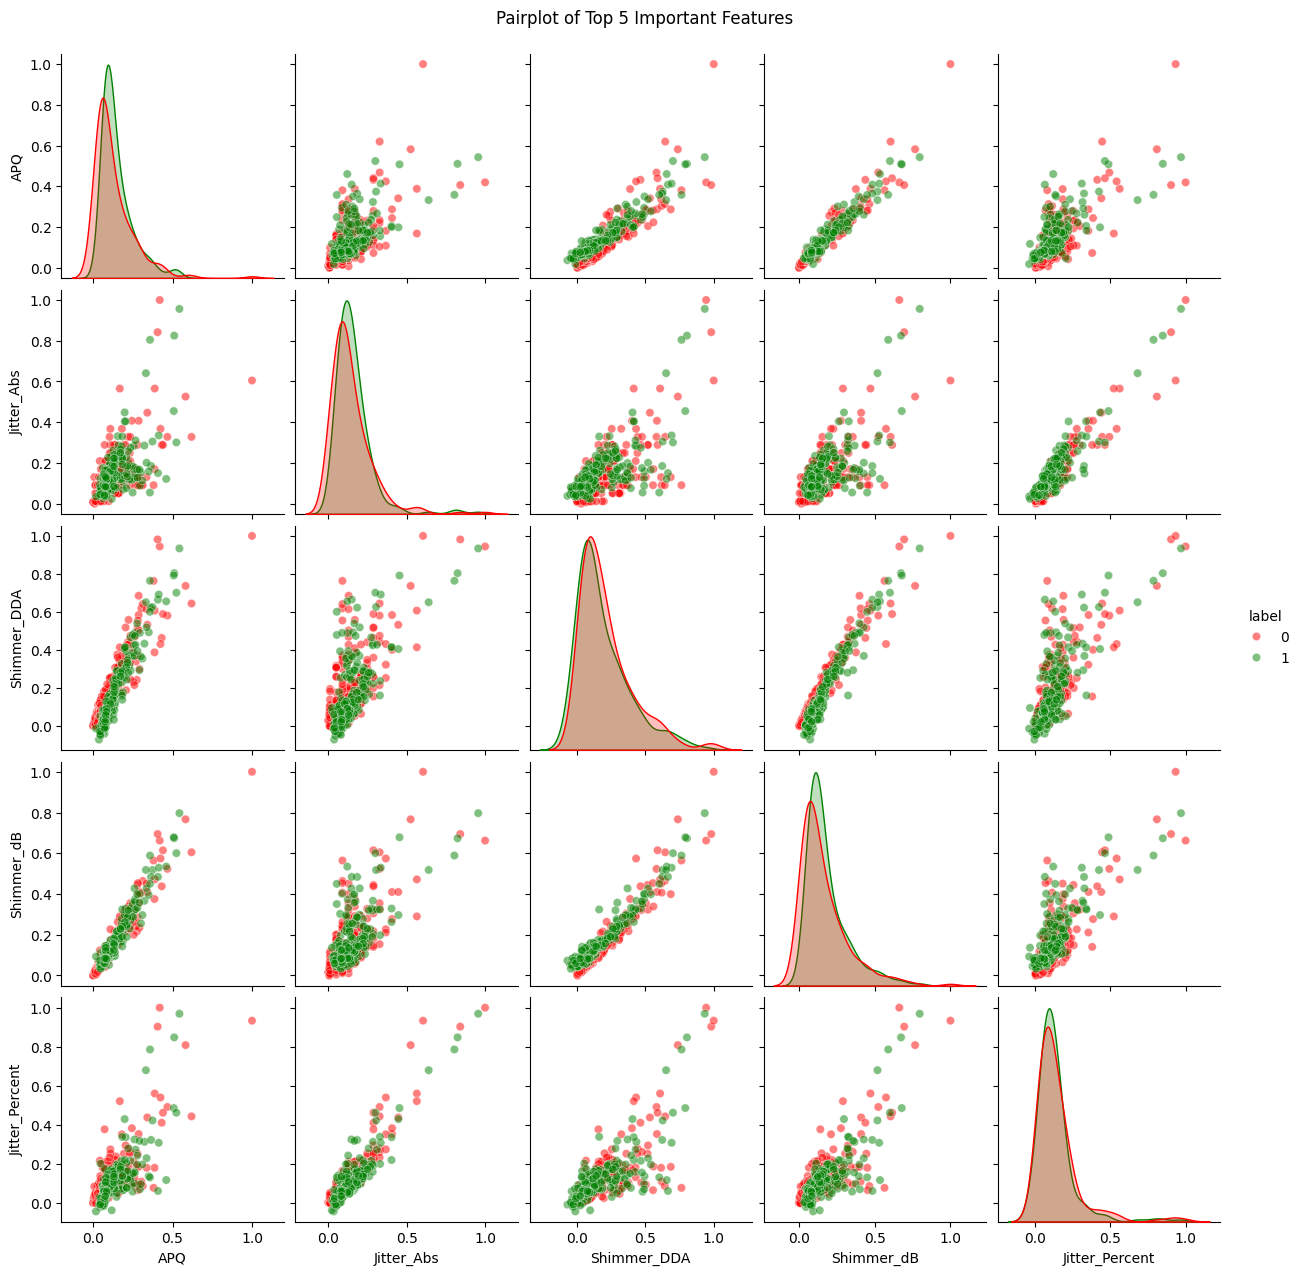

In [ ]:
pairplot_df = combined[top_features.index.tolist() + ['label']]

sns.pairplot(pairplot_df, hue='label', palette={1: "green", 0: "red"}, plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Top 5 Important Features", y=1.02)
plt.show()

In [ ]:
for col in data_no_status.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(data_no_status[col], label="Real", kde=True, color="blue", alpha=0.5)
    sns.histplot(X[col], label="Fake", kde=True, color="red", alpha=0.5)
    plt.legend()
    plt.title(f"Feature: {col}")
    plt.show()

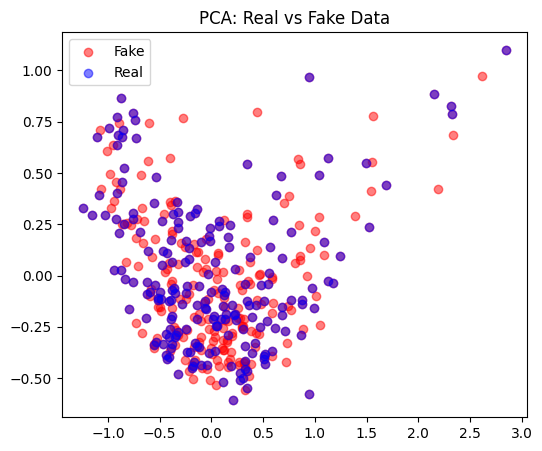

In [ ]:
real_np = data_no_status.to_numpy()
fake_np = X.to_numpy()

pca = PCA(n_components=2)
data_pca = pca.fit_transform(real_np)
fake_pca = pca.transform(fake_np)

plt.figure(figsize=(6, 5))
plt.scatter(fake_pca[:, 0], fake_pca[:, 1], label="Fake", alpha=0.5, color="red")
plt.scatter(data_pca[:, 0], data_pca[:, 1], label="Real", alpha=0.5, color="blue")
plt.legend()
plt.title("PCA: Real vs Fake Data")
plt.show()

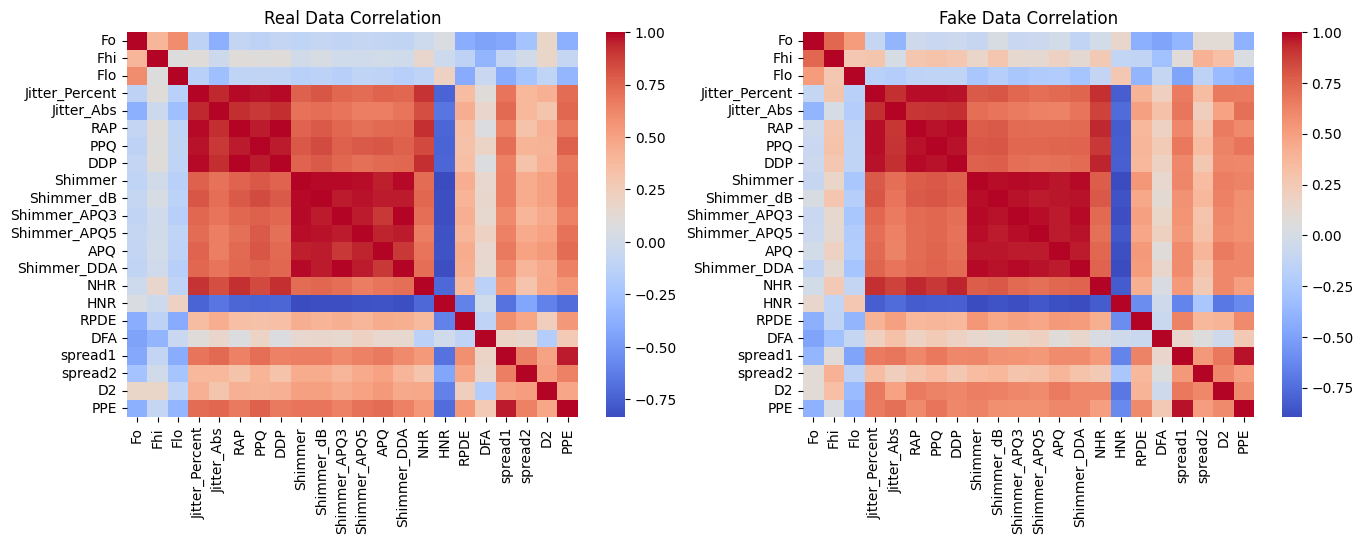

In [ ]:
corr_real = data_no_status.corr()
corr_fake = fake.corr()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(corr_real, ax=axes[0], cmap="coolwarm")
axes[0].set_title("Real Data Correlation")

sns.heatmap(corr_fake, ax=axes[1], cmap="coolwarm")
axes[1].set_title("Fake Data Correlation")

plt.show()

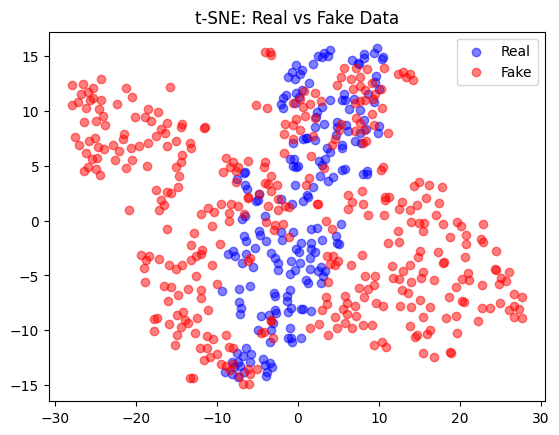

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2)
real_tsne = tsne.fit_transform(real_np)
fake_tsne = tsne.fit_transform(fake_np)

plt.scatter(real_tsne[:, 0], real_tsne[:, 1], label="Real", alpha=0.5, color="blue")
plt.scatter(fake_tsne[:, 0], fake_tsne[:, 1], label="Fake", alpha=0.5, color="red")
plt.legend()
plt.title("t-SNE: Real vs Fake Data")
plt.show()